## Sega Genesis .anim File
This notebook helps analyze and extract components from *anim format files used in Sega Genesis/Mega Drive development.

Components we'll extract:
1. Header information
2. Palette data (with visualization)
3. Stamp/tile data
4. Map data

## .anim file to PNG with default palette

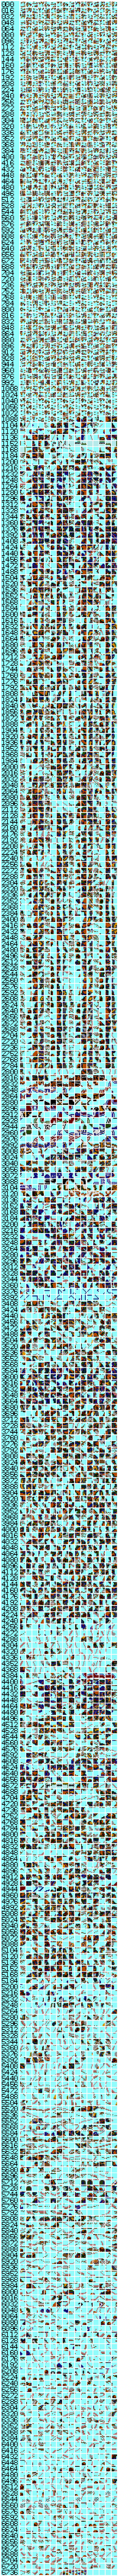


Total tiles: 6747
Grid size: 16x422


In [13]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import math
import os

def load_genesis_palette(pal_str):
    return [tuple(int(color[i:i+2], 16) for i in (0, 2, 4)) for color in pal_str.split()]

def read_4bpp_tiles(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    
    tile_size = 8 * 8
    bytes_per_tile = tile_size // 2
    total_tiles = len(data) // bytes_per_tile
    grid_width = 16
    grid_height = math.ceil(total_tiles / grid_width)
    
    # Create larger array to accommodate row numbers on left
    margin_left = 24  # Smaller margin for row numbers
    pixels = np.zeros((grid_height * 8, grid_width * 8 + margin_left), dtype=np.uint8)
    
    # Fill margin area with light blue color (index 0 in palette)
    pixels[:, :margin_left] = 0
    
    for tile_idx in range(total_tiles):
        tile_y = tile_idx // grid_width
        tile_x = tile_idx % grid_width
        tile_offset = tile_idx * bytes_per_tile
        
        # Adjust x position for margin
        pixel_x = margin_left + (tile_x * 8)
        pixel_y = tile_y * 8
        
        for y in range(8):
            for x in range(0, 8, 2):
                if tile_offset >= len(data):
                    break
                byte = data[tile_offset]
                pixels[pixel_y + y, pixel_x + x] = (byte >> 4) & 0xF
                pixels[pixel_y + y, pixel_x + x + 1] = byte & 0xF
                tile_offset += 1
    
    return pixels, total_tiles, grid_height, grid_width

# Load palette
palette_str = "90FCFC D8D8D8 909090 484848 242424 D89000 B46C00 000000 242490 00006C 244800 002400 B44800 6C0000 B46C6C 6C4824"
palette = load_genesis_palette(palette_str)

# Load image data
image_data, total_tiles, grid_height, grid_width = read_4bpp_tiles('src/graphics/sprites.anim')

# Create PIL image
image = Image.fromarray(image_data.astype('uint8'), mode='P')
image.putpalette([x for color in palette for x in color] + [0] * (768 - len(palette) * 3))

# Convert to RGB for drawing
image = image.convert('RGB')
draw = ImageDraw.Draw(image)

# Try to load a small font
try:
    font = ImageFont.truetype("notebooks/fonts/PixeloidMono-d94EV.ttf", 8)
except:
    try:
        font = ImageFont.truetype("cour.ttf", 8)
    except:
        font = ImageFont.load_default()

# Draw grid lines
margin_left = 24
for y in range(0, image.height, 8):
    draw.line([(margin_left, y), (image.width, y)], fill='white', width=1)
for x in range(margin_left, image.width, 8):
    draw.line([(x, 0), (x, image.height)], fill='white', width=1)

# Add row numbers
for row in range(grid_height):
    base_tile = row * grid_width
    y_pos = row * 8  # Align to top of row
    text = f"{base_tile:03d}"
    # Draw text in black
    draw.text((1, y_pos), text, font=font, fill='black')

# Save image
if not os.path.exists('extracted_output'):
    os.makedirs('extracted_output')
image.save('extracted_data/sprites_tiles_numbered.png')

# Display image
aspect_ratio = image_data.shape[0] / image_data.shape[1]
plt.figure(figsize=(15, 15 * aspect_ratio))
plt.imshow(image)
plt.axis('off')
plt.show()

print(f"\nTotal tiles: {total_tiles}")
print(f"Grid size: {grid_width}x{grid_height}")